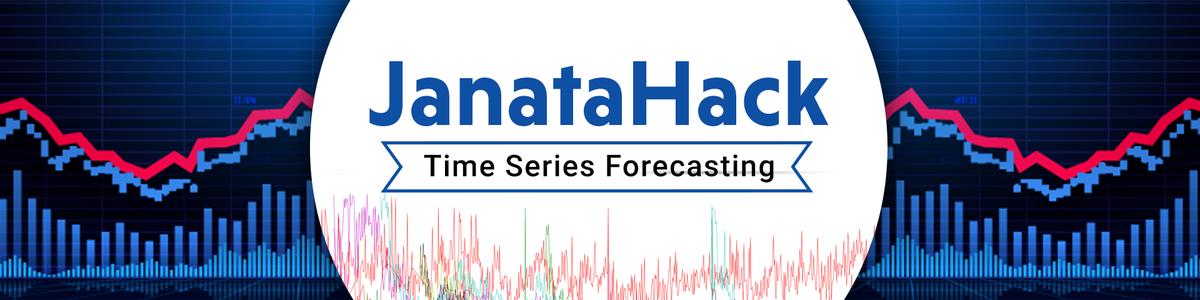

In [46]:
from PIL import Image
read_image=Image.open('/jantahackathon time series/cover-thumbnail-1200x1200.png')
read_image

Company of Electrolysia supplies electricity to the city. It is looking to optimise its electricity production based on the historical electricity consumption of the people of Electrovania. 
 
The company has hired you as a Data Scientist to investigate the past consumption and the weather information to come up with a model that catches the trend as accurately as possible. You have to bear in mind that there are many factors that affect electricity consumption and not all can be measured. Electrolysia has provided you this data on hourly data spanning five years. 
 
For this competition, the training set is comprised of the first 23 days of each month and the test set is the 24th to the end of the month, where the public leaderboard is based on the first two days of test, whereas the private leaderboard considers the rest of the days. Your task is to predict the electricity consumption on hourly basis.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
from statsmodels.tsa.stattools import acf,pacf
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=10,6
from pandas.plotting import lag_plot
from pandas import datetime
from sklearn.metrics import mean_squared_error
from pmdarima.arima.utils import ndiffs
import pmdarima as pm
import  statsmodels.api as sm

<ipython-input-1-12ee4fa5e4f5>:13: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
df_train=pd.read_csv('/jantahackathon time series/train_6BJx641.csv',parse_dates = [1],index_col = [1],  squeeze = True)
df_train.head()

,ID,temperature,var1,pressure,windspeed,var2,electricity_consumption
datetime,,,,,,,
2013-07-01 00:00:00,0,-11.4,-17.1,1003.0,571.910,A,216.0
2013-07-01 01:00:00,1,-12.1,-19.3,996.0,575.040,A,210.0
2013-07-01 02:00:00,2,-12.9,-20.0,1000.0,578.435,A,225.0
2013-07-01 03:00:00,3,-11.4,-17.1,995.0,582.580,A,216.0
2013-07-01 04:00:00,4,-11.4,-19.3,1005.0,586.600,A,222.0


In [3]:
df_train.tail()

,ID,temperature,var1,pressure,windspeed,var2,electricity_consumption
datetime,,,,,,,
2017-06-23 19:00:00,34891,-0.7,-15.0,1009.0,51.685,A,225.0
2017-06-23 20:00:00,34892,-2.9,-11.4,1005.0,56.105,A,213.0
2017-06-23 21:00:00,34893,-1.4,-12.9,995.0,61.275,A,213.0
2017-06-23 22:00:00,34894,-2.9,-11.4,996.0,67.210,A,210.0
2017-06-23 23:00:00,34895,-2.1,-11.4,1009.0,71.880,A,210.0


In [4]:
df_test=pd.read_csv('/jantahackathon time series/test_pavJagI.csv')
df_test.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A


In [5]:
sample=pd.read_csv('/jantahackathon time series/sample_submission_bYgKb77.csv')
sample.head()

,ID,electricity_consumption
0,552,0
1,553,0
2,554,0
3,555,0
4,556,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2013-07-01 00:00:00 to 2017-06-23 23:00:00
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       26496 non-null  int64  
 1   temperature              26496 non-null  float64
 2   var1                     26496 non-null  float64
 3   pressure                 26496 non-null  float64
 4   windspeed                26496 non-null  float64
 5   var2                     26496 non-null  object 
 6   electricity_consumption  26496 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.6+ MB


In [7]:
df_train.describe()

,ID,temperature,var1,pressure,windspeed,electricity_consumption
count,26496.000000,26496.000000,26496.000000,26496.000000,26496.000000,26496.000000
mean,17455.500000,5.098989,-1.916233,986.450615,23.959956,298.359601
std,10122.873673,8.682860,10.424860,12.002647,48.280321,108.020555
min,0.000000,-17.100000,-32.900000,953.000000,1.075000,174.000000
25%,8717.750000,-2.900000,-10.700000,978.000000,3.155000,219.000000
50%,17435.500000,6.400000,-1.400000,986.000000,6.545000,267.000000
75%,26177.250000,12.100000,7.900000,995.000000,22.260000,342.000000
max,34895.000000,23.600000,18.600000,1024.000000,586.600000,1386.000000


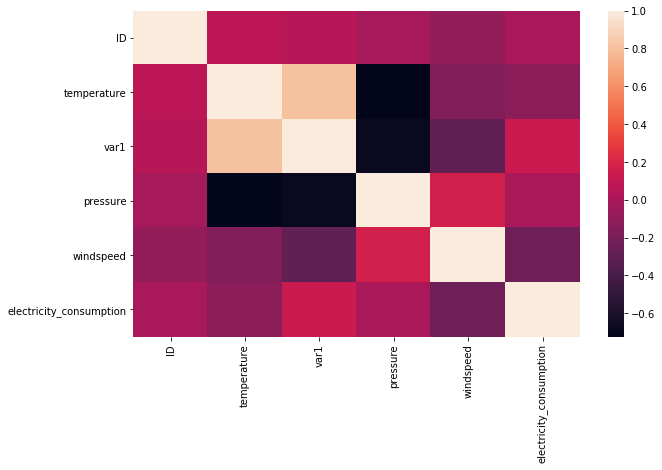

In [8]:
import seaborn as sns
sns.heatmap(df_train.corr())

In [9]:
df_train.var2.value_counts()

A    25239
C     1040
B      217
Name: var2, dtype: int64

In [10]:
df_train_copy=df_train
#temperature	var1	pressure	windspeed	var2	
df_train_copy=df_train_copy.drop(['temperature','var1','pressure','windspeed','var2','ID'],axis=1)

In [11]:
df_train_copy.head()

,electricity_consumption
datetime,
2013-07-01 00:00:00,216.0
2013-07-01 01:00:00,210.0
2013-07-01 02:00:00,225.0
2013-07-01 03:00:00,216.0
2013-07-01 04:00:00,222.0


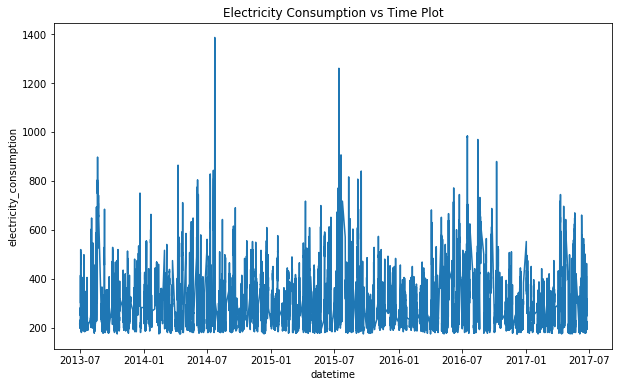

In [12]:
plt.title('Electricity Consumption vs Time Plot')
plt.xlabel('datetime')
plt.ylabel('electricity_consumption')
plt.plot(df_train_copy)
plt.show()

In [13]:
df_mean=df_train_copy.rolling(window=100).mean()

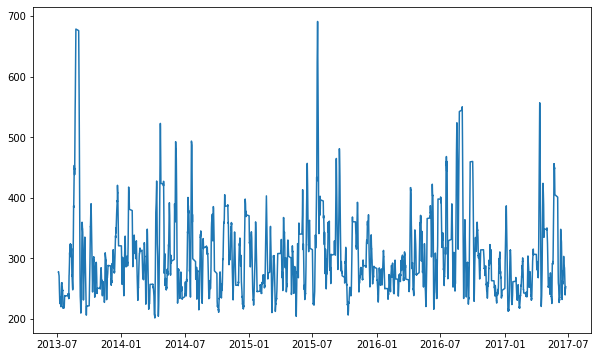

In [14]:
plt.plot(df_mean)

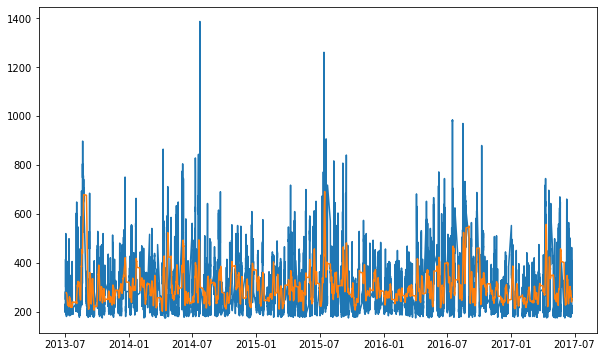

In [15]:
plt.plot(df_train_copy)
plt.plot(df_mean)
plt.show()

In [16]:
#Splitting data to Test:Train
train = df_train_copy[0:24427] 
test = df_train_copy[24427:]

In [17]:
train.size,test.size

(24427, 2069)

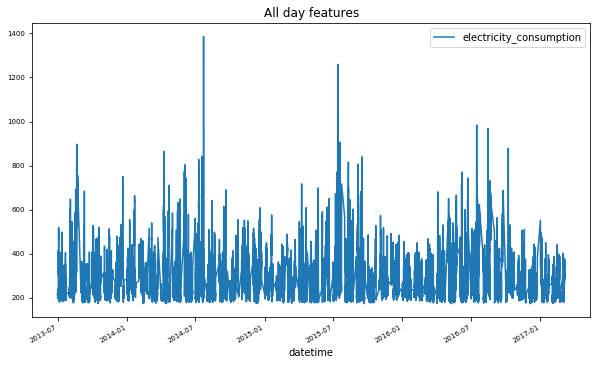

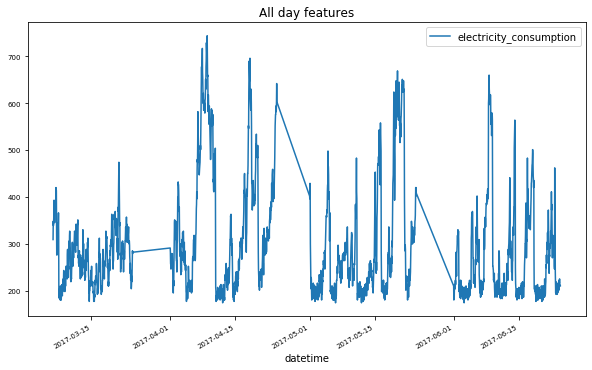

In [18]:
train.plot( title= 'All day features', fontsize=7)
test.plot( title= 'All day features', fontsize=7) 
plt.show()

In [19]:
# extract out the time-series
train_feature =  train['electricity_consumption']
test_feature =  test['electricity_consumption']

In [20]:
from statsmodels.tsa.stattools import adfuller

df_test = adfuller(train.electricity_consumption)
df_test

(-16.66918233366908,
 1.550229291953661e-29,
 38,
 24388,
 {'1%': -3.4306181641964435,
  '5%': -2.861658520324639,
  '10%': -2.5668330849261767},
 238576.0533045981)

In [21]:
print('DF test statistic is %3.3f' %df_test[0])
print('DF test p-value is %1.4f' %df_test[1])

DF test statistic is -16.669
DF test p-value is 0.0000


Since p-value < 0.05. Reject Null Hypothesis.

In [22]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [23]:
# plot_acf is to identify parameter q
# ARIMA (p,d,q)

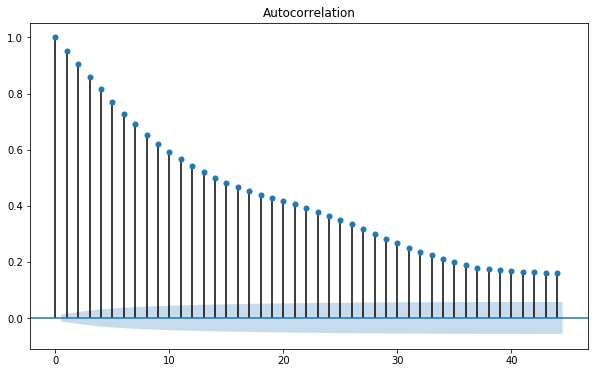

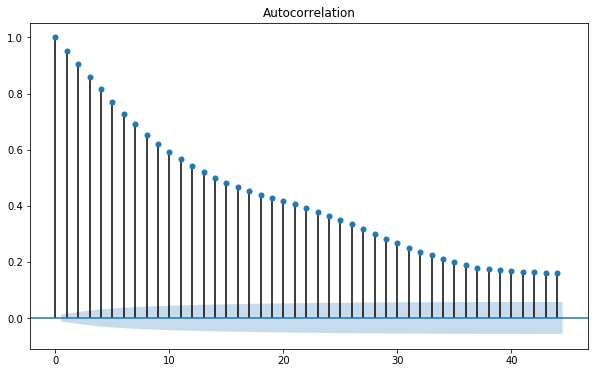

In [24]:
plot_acf(train) #identify the value of q

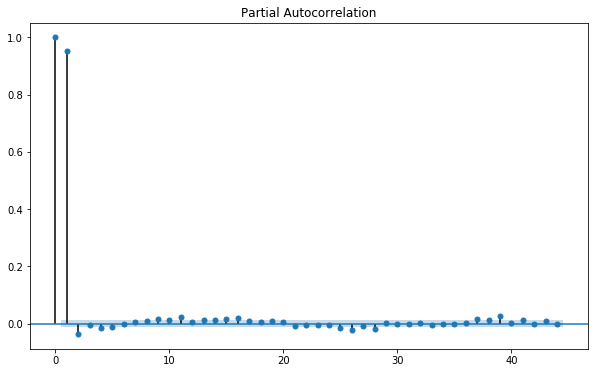

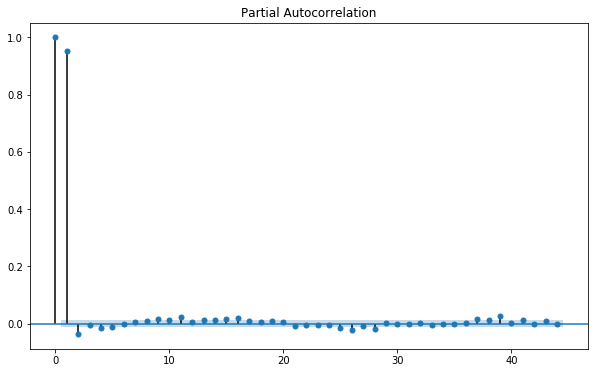

In [25]:
plot_pacf(train)  #identify the value of p

In [26]:
model=ARIMA(train,order=(2,0,0))

/home/kumar/miniconda3/envs/DS_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [27]:
model_fit=model.fit()

In [28]:
model_fit.aic

239072.55394145485

In [29]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2069 entries, 2017-03-06 19:00:00 to 2017-06-23 23:00:00
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   electricity_consumption  2069 non-null   float64
dtypes: float64(1)
memory usage: 32.3 KB


In [30]:
model_forecast=model_fit.forecast(steps=2069)[0]

In [31]:
pd.DataFrame(model_forecast).size

2069

In [32]:
model_forecast.size,test.size

(2069, 2069)

In [33]:
model_forecast=pd.DataFrame(model_forecast)
model_forecast.head()
model_forecast.column=['Forecast']

<ipython-input-33-eed609e1b973>:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  model_forecast.column=['Forecast']


/home/kumar/miniconda3/envs/DS_env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


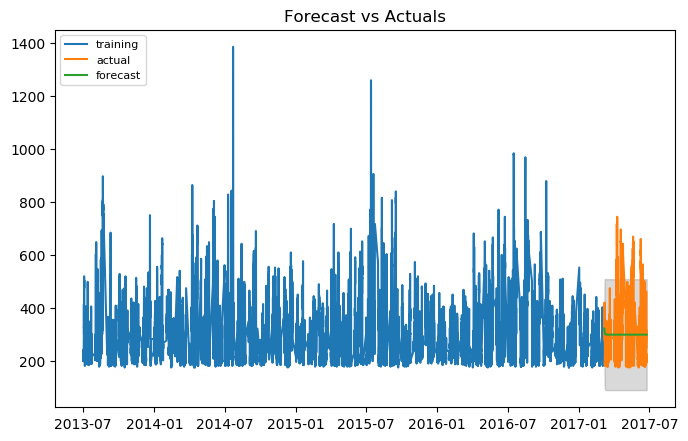

In [34]:
# Build Model 
model = ARIMA(train_feature, order=(2,0,0)) #Chosen this combination of p,q,d after trying other combinations 
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(2069, alpha=0.05)  

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(8,5), dpi=100)
plt.plot(train_feature, label='training')
plt.plot(test_feature, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [35]:
forecast = fitted.forecast(steps=34511)[0]

In [36]:
forecast=pd.DataFrame(forecast)

In [37]:
pred = pd.read_csv('/jantahackathon time series/test_pavJagI.csv')

In [38]:
pred.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A


In [39]:
pred['electricity_consumption'] = forecast
pred.head()

,ID,datetime,temperature,var1,pressure,windspeed,var2,electricity_consumption
0,552,2013-07-24 00:00:00,-10.0,-16.4,1011.0,263.280,A,321.213112
1,553,2013-07-24 01:00:00,-10.0,-20.7,1011.0,267.175,A,320.111979
2,554,2013-07-24 02:00:00,-10.7,-17.1,1003.0,269.555,A,319.016232
3,555,2013-07-24 03:00:00,-13.6,-20.7,1008.0,273.060,A,317.973691
4,556,2013-07-24 04:00:00,-10.7,-17.1,1006.0,1.765,A,316.983527


In [40]:
#datetime	temperature	var1	pressure	windspeed	var2
pred=pred.drop(['datetime','temperature','var1','pressure','windspeed','var2'],axis=1)
pred.head()

,ID,electricity_consumption
0,552,321.213112
1,553,320.111979
2,554,319.016232
3,555,317.973691
4,556,316.983527


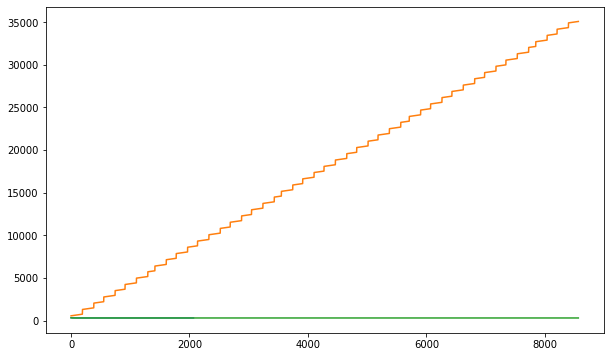

In [41]:
plt.plot(model_forecast)
plt.plot(pred)
plt.show()

In [42]:
pred.to_csv('/jantahackathon time series/Final_submission.csv')

In [43]:
from sklearn.metrics import r2_score

In [44]:
score=r2_score(test,model_forecast)
score

0.0006017269578674211

In [45]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=5, max_q=5, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=2, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA: (1, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=239072.875, BIC=239105.289, Time=13.836 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=297612.770, BIC=297628.976, Time=0.722 seconds
Fit ARIMA: (1, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=239103.005, BIC=239127.316, Time=1.761 seconds
Fit ARIMA: (0, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=273267.817, BIC=273292.127, Time=10.902 seconds
Fit ARIMA: (0, 0, 0)x(0, 0, 0, 0) (constant=False); AIC=350657.728, BIC=350665.831, Time=0.403 seconds
Fit ARIMA: (2, 0, 1)x(0, 0, 0, 0) (constant=True); AIC=239074.483, BIC=239115.001, Time=12.526 seconds
Fit ARIMA: (1, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=239075.012, BIC=239115.529, Time=5.977 seconds
Fit ARIMA: (0, 0, 2)x(0, 0, 0, 0) (constant=True); AIC=260216.116, BIC=260248.530, Time=20.796 seconds
Fit ARIMA: (2, 0, 0)x(0, 0, 0, 0) (constant=True); AIC=239072.555, BIC=239104.969, Time=3.003 seconds
Fit ARIMA: (3, 0, 0)x(0, 0, 0, 0) 